In [1]:
# EDRDAE Model

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

2023-06-01 15:10:15.949668: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-01 15:10:16.655858: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
dataset = h5py.File('./dataset/data_both.h5', 'r')
train = np.array(dataset['train'])
test = np.array(dataset['test'])
def shift_data(inputs):
    if len(inputs.shape) == 1:
        inputs = inputs[np.newaxis]
    for i in range(inputs.shape[0]):
        shift_int = np.random.randint(1, 200, size=1)
        zero_vecs = np.zeros([1, inputs.shape[1]])
        zero_vecs[:, :-shift_int[0]] = inputs[i, shift_int[0]:]
        inputs[i, :] = zero_vecs[:,:]
    return inputs

In [3]:
np.random.randint(0,2)

1

In [4]:
test[0].shape

(1300,)

In [5]:
dataset = h5py.File('./dataset/data_both.h5', 'r')
train = np.array(dataset['train'])
test = np.array(dataset['test'])
def shift_data(inputs):
    if len(inputs.shape) == 1:
        inputs = inputs[np.newaxis]
    for i in range(inputs.shape[0]):
        shift_int = np.random.randint(1, 200, size=1)
        zero_vecs = np.zeros([1, inputs.shape[1]])
        zero_vecs[:, :-shift_int[0]] = inputs[i, shift_int[0]:]
        inputs[i, :] = zero_vecs[:,:]
    return inputs

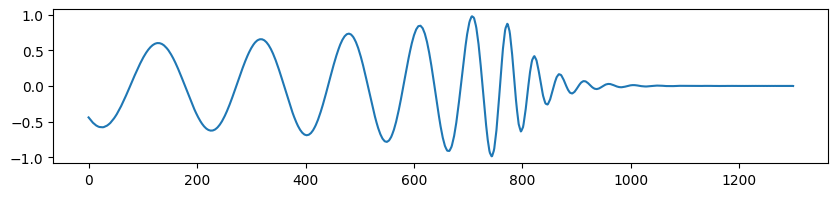

In [6]:
fig = plt.figure(figsize=(10,2))
plt.plot(test[0])
plt.show()

In [7]:
shifted = shift_data(test)

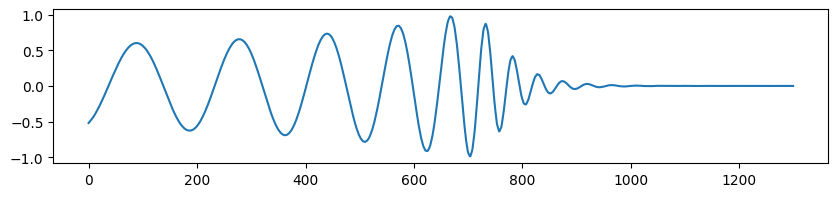

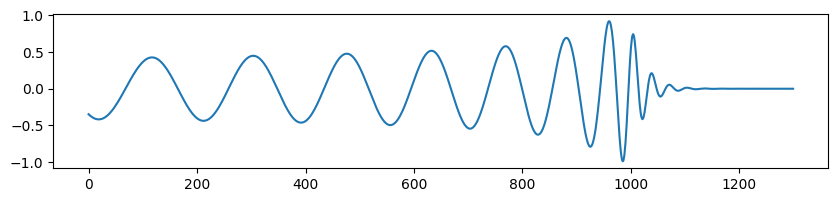

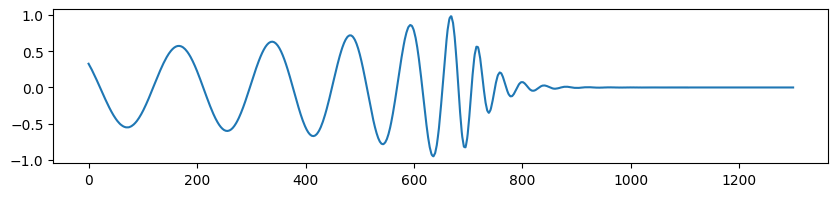

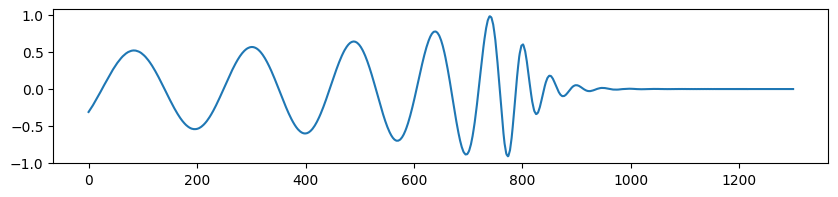

In [8]:
for i in range(4): 
    fig = plt.figure(figsize=(10,2))
    plt.plot(shifted[i])
    plt.show()

In [9]:
# add Gaussian Noise
def add_gaussian_noise(original, SNR):
    noisy_input = original + np.random.normal(0,1/SNR,original.shape)
    return noisy_input

In [10]:
def get_small_time(noise_samlpe, clean_sample):
    num_subarrays = len(noise_samlpe) // 9
    noise_res = []
    clean_res = []
    for i in range(num_subarrays):
        start_index = i * 9
        end_index = start_index + 9
        noise = noise_samlpe[start_index:end_index]
        clean = clean_sample[start_index:end_index]
        noise_res.append(noise)
        clean_res.append(clean)

    # Check if there are remaining elements that require padding
    remaining_elements = len(noise_samlpe) % 9
    if remaining_elements > 0:
        last_subarray_noise = noise_samlpe[-remaining_elements:]
        last_subarray_noise = np.pad(last_subarray_noise, (0, 9 - remaining_elements), 'constant')
        noise_res.append(last_subarray_noise)

        last_subarray_clean = clean_sample[-remaining_elements:]
        last_subarray_clean = np.pad(last_subarray_clean, (0, 9 - remaining_elements), 'constant')
        clean_res.append(last_subarray_clean)
    
    noise_res = np.array(noise_res)
    clean_res = np.array(clean_res)
    print(noise_res.shape, clean_res.shape)
    return [noise_res, clean_res]


In [11]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, TimeDistributed


# Custom layer for scalar multiplication to use as signal amplifier
class ScalarMultiplyLayer(layers.Layer):
    def __init__(self):
        super(ScalarMultiplyLayer, self).__init__()
        self.scalar = self.add_weight(shape=(1,), initializer='ones', trainable=True)

    def call(self, inputs):
        return inputs * self.scalar

# Define the EDRDAE model architecture
# Paper describes: one encoder layer followed by two decoder
# layers with bidirectional LSTM cells
def build_edrdae_model(input_shape, num_layers, num_channels):
    model = keras.Sequential()
    print('DEBUG: ', input_shape)
    


    # Encoder
    encoder = layers.Bidirectional(layers.LSTM(num_channels, return_sequences=True), input_shape=input_shape)
    model.add(encoder)

    # Hidden layers
    #for _ in range(num_layers):
    #    hidden_layer = layers.Bidirectional(layers.LSTM(num_channels, return_sequences=True))
    #    model.add(hidden_layer)
    
    # Decoder
    decoder_layer1 = layers.Bidirectional(layers.LSTM(num_channels, return_sequences=True))
    model.add(decoder_layer1)
    decoder_layer2 = layers.Bidirectional(layers.LSTM(num_channels, return_sequences=True))
    model.add(decoder_layer2)

    # Signal Amplifier
    #signal_amplifier = layers.Dense(num_channels, activation='relu')
    #model.add(signal_amplifier)


    
    model.add(Dense(1, activation='linear'))

    # Signal Amplifier
    model.add(ScalarMultiplyLayer())
    
    return model


# Define the model parameters
timesteps = 1300  # (timestep of 9 was best in paper)
num_layers = 4  # Number of decoder layers, (4 best in paper)
num_channels = 64  # Number of channels for LSTM cells

# Reshape the input shape to match the training data
input_shape = (timesteps, 1)

# Build the EDRDAE model
model = build_edrdae_model(input_shape, num_layers, num_channels)



# Compile the model
lr = 0.0001  # learning rate
adam = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=adam, loss='mse')




2023-06-01 15:10:18.912748: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-01 15:10:18.939344: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-01 15:10:18.939649: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

DEBUG:  (1300, 1)


2023-06-01 15:10:19.846169: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-01 15:10:19.847444: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-01 15:10:19.848721: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 1300, 128)        33792     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 1300, 128)        98816     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 1300, 128)        98816     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1300, 1)           129       
                                                                 
 scalar_multiply_layer (Scal  (None, 1300, 1)          1         
 arMultiplyLayer)                                       

In [13]:
# make number of timesteps divisible by 9
# 1300 // 9 = 144
# Padd inputs with zeros at the end to have 145 9 timestep sequences
padded_train = np.pad(train, [(0, 0), (0, 5)], mode='constant')

for i, wave in enumerate(padded_train):
    if i > 3:
        break
    print(wave.shape)

(1305,)
(1305,)
(1305,)
(1305,)


In [14]:
# Split the array into 145 arrays of length 9
split_arr = np.array_split(padded_train, 145)

In [ ]:
batch_size_ = 30


# Curriculum Learning
initial_snr = 2.0  # Initial Signal-to-Noise Ratio (SNR)
final_snr = 0.5  # Final SNR
num_iterations = 2000  # Number of iterations for each SNR level
num_steps = 1  # Number of steps to gradually decrease the SNR

earlystop = tf.keras.callbacks.EarlyStopping(
    monitor="loss",
    min_delta=0,
    patience=10,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

for step in range(num_steps):
    current_snr = initial_snr - (step * (initial_snr - final_snr) / num_steps)
    print(f"Training with SNR: {current_snr}")
    
    shifted = shift_data(train)
    # Generate noisy training data with current SNR
    x_train_noisy = add_gaussian_noise(shifted, current_snr)
    
    #print(x_train_noisy.shape, just_test.shape)
    shifted = train.reshape((len(train), timesteps, 1))
    x_train_noisy = x_train_noisy.reshape((len(train), timesteps, 1))

    # Train the model with current SNR
    history = model.fit(x_train_noisy, shifted, batch_size=batch_size_, callbacks= [earlystop], epochs=num_iterations)

Training with SNR: 2.0
Epoch 1/2000


2023-06-01 15:10:37.801880: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-01 15:10:37.803415: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-01 15:10:37.804795: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

329/329 [==============================] - 73s 195ms/step - loss: 0.0169
Epoch 2/2000
329/329 [==============================] - 64s 196ms/step - loss: 0.0113
Epoch 3/2000
329/329 [==============================] - 64s 195ms/step - loss: 0.0060
Epoch 4/2000
329/329 [==============================] - 65s 197ms/step - loss: 0.0041
Epoch 5/2000
329/329 [==============================] - 65s 197ms/step - loss: 0.0037
Epoch 6/2000
329/329 [==============================] - 64s 194ms/step - loss: 0.0035
Epoch 7/2000
125/329 [==========>...................] - ETA: 40s - loss: 0.0033

In [ ]:
batch_size_ = 30


# Curriculum Learning
initial_snr = 2.0-0.15  # Initial Signal-to-Noise Ratio (SNR)
final_snr = 0.5  # Final SNR
num_iterations = 2000  # Number of iterations for each SNR level
num_steps = 2  # Number of steps to gradually decrease the SNR

earlystop = tf.keras.callbacks.EarlyStopping(
    monitor="loss",
    min_delta=0,
    patience=10,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

for step in range(num_steps):
    current_snr = initial_snr - (step * (initial_snr - final_snr) / num_steps)
    print(f"Training with SNR: {current_snr}")
    
    shifted = shift_data(train)
    # Generate noisy training data with current SNR
    x_train_noisy = add_gaussian_noise(shifted, current_snr)
    
    #print(x_train_noisy.shape, just_test.shape)
    shifted = train.reshape((len(train), timesteps, 1))
    x_train_noisy = x_train_noisy.reshape((len(train), timesteps, 1))

    # Train the model with current SNR
    history = model.fit(x_train_noisy, shifted, batch_size=batch_size_, callbacks= [earlystop], epochs=num_iterations)

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model.save('test_train3.h5')

In [ ]:
#model = load_model('./test_train.h5')

In [ ]:
snr = 0.6

In [ ]:
test_noisy = add_gaussian_noise(test, snr)

In [ ]:
%%time
predictions = model.predict(test_noisy, batch_size=300)
predictions = predictions.reshape(predictions.shape[0], predictions.shape[1])

In [ ]:
predictions.shape

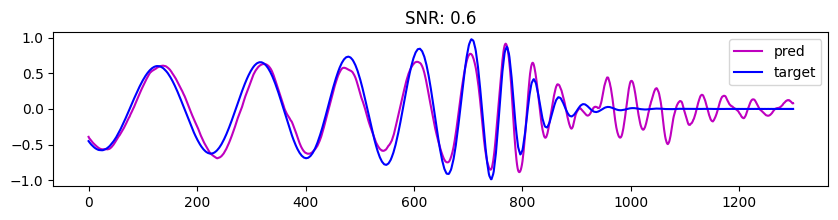

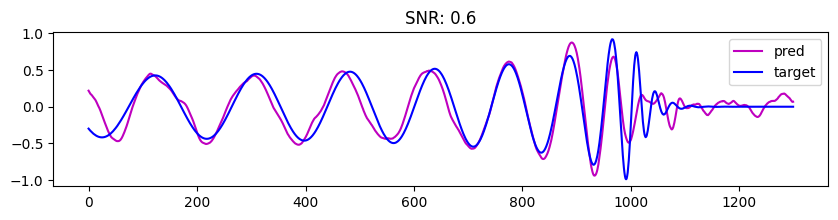

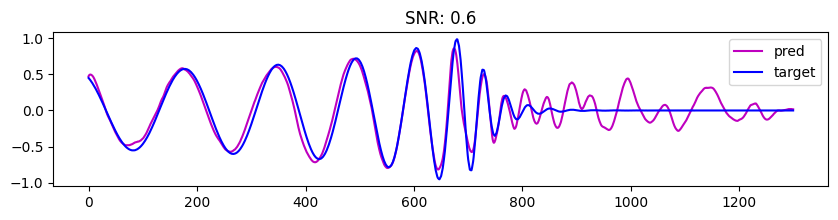

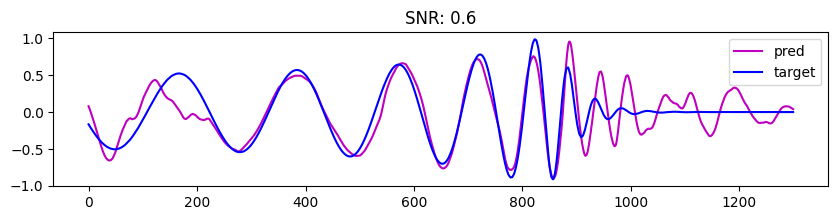

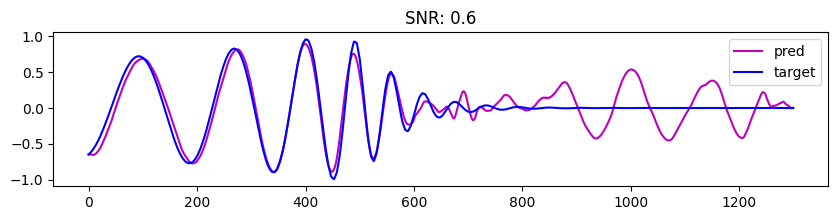

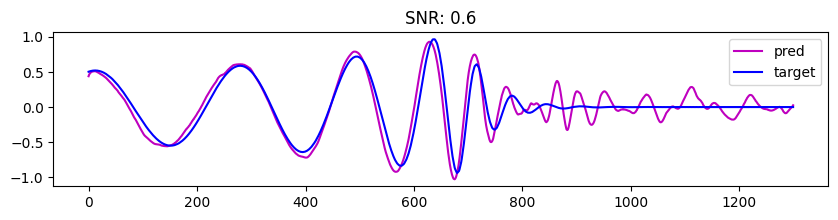

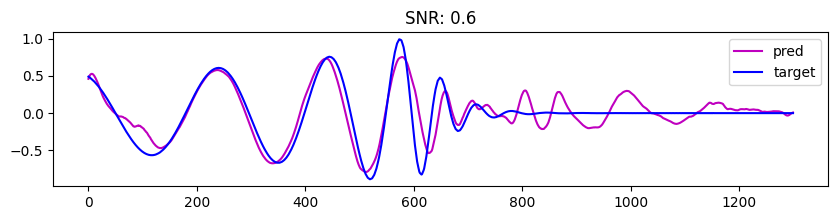

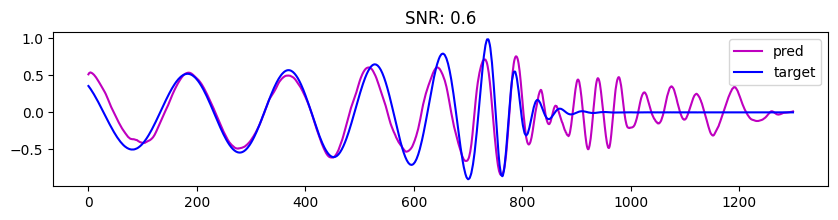

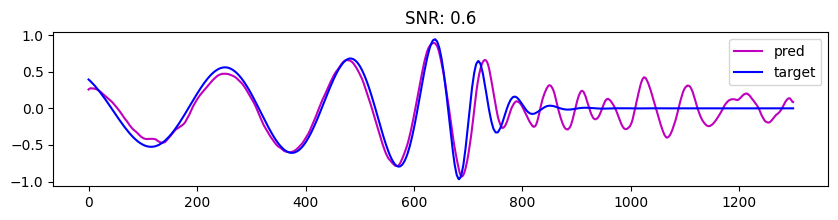

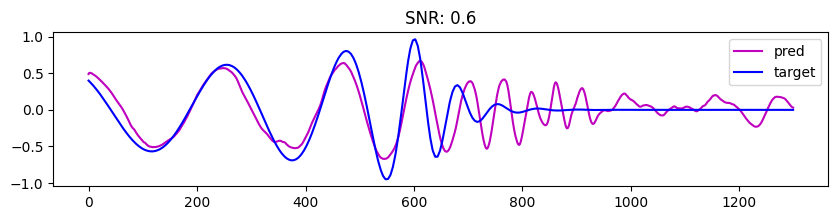

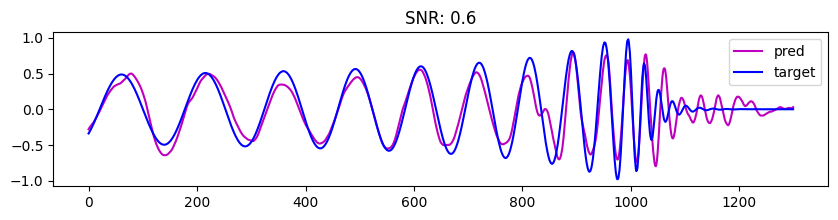

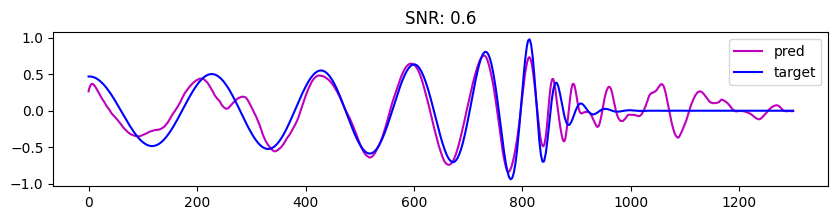

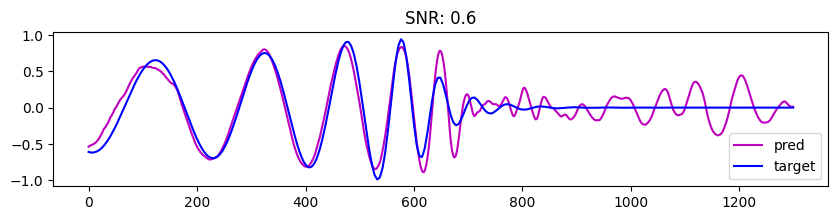

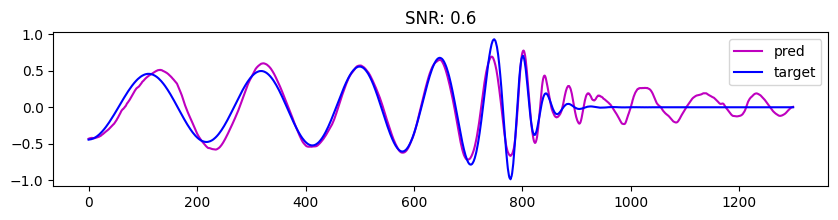

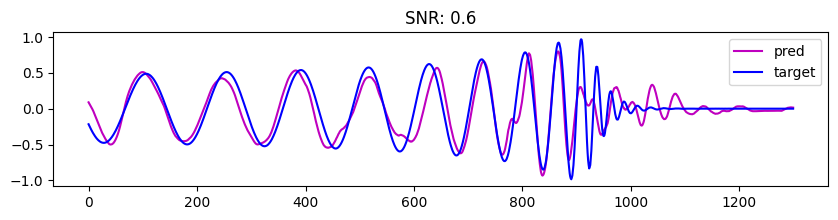

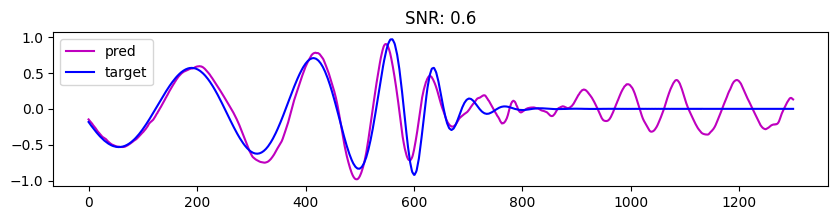

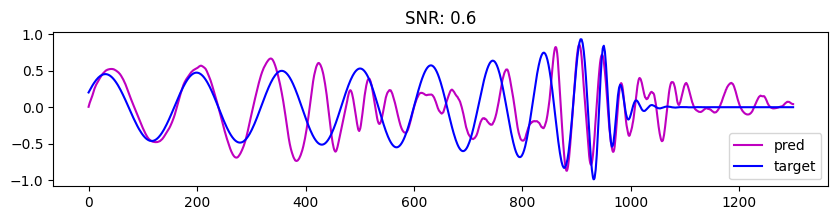

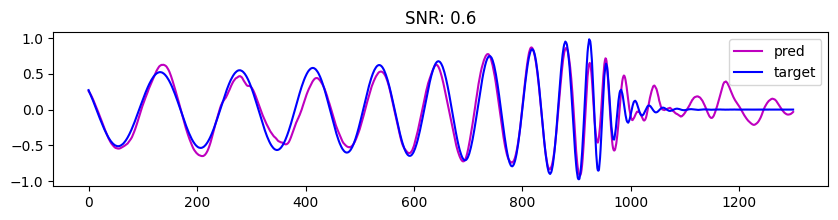

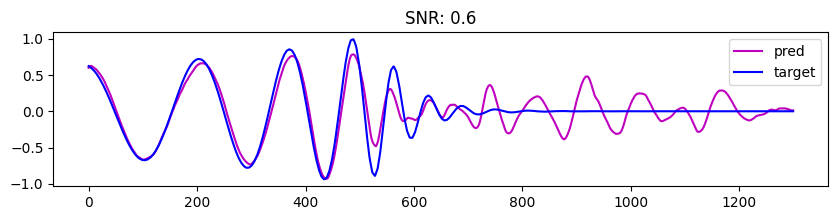

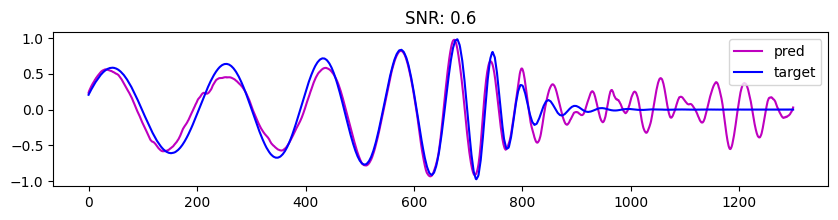

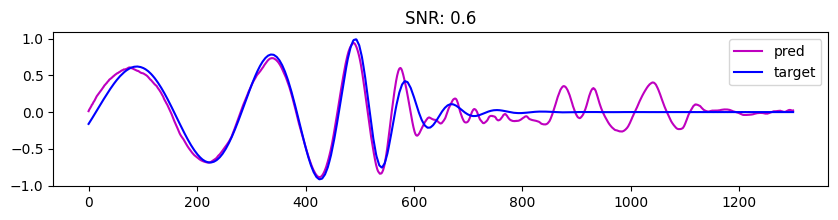

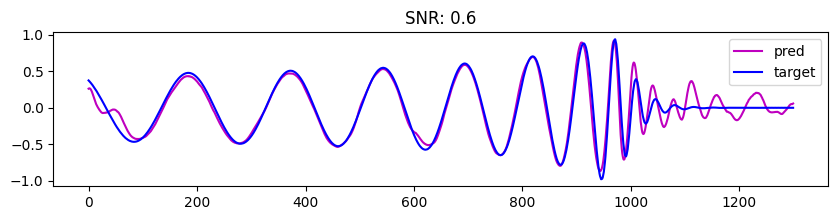

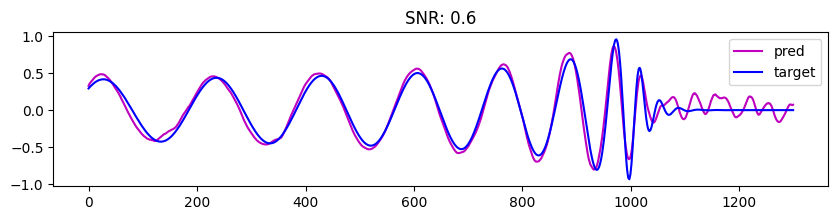

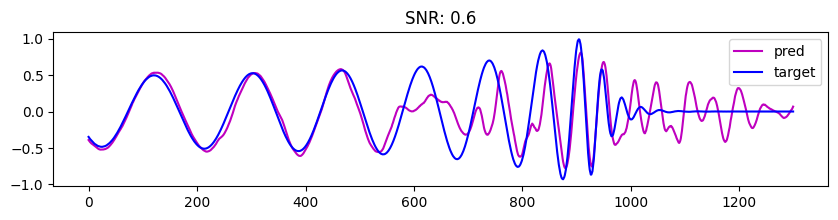

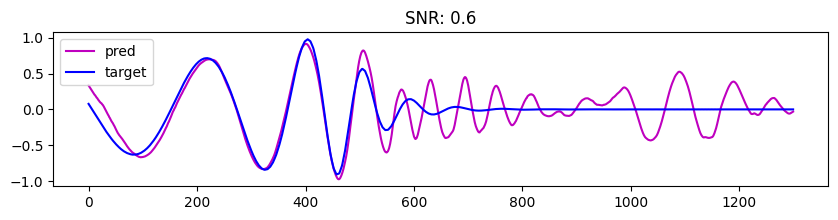

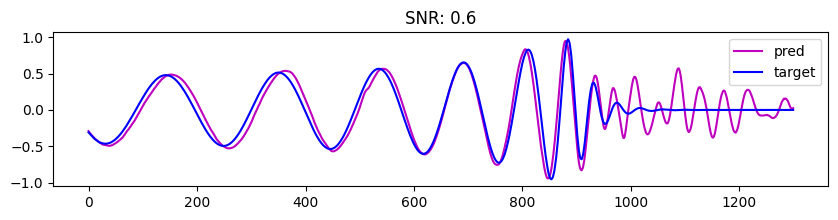

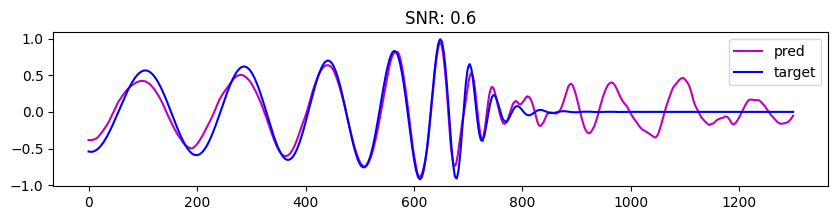

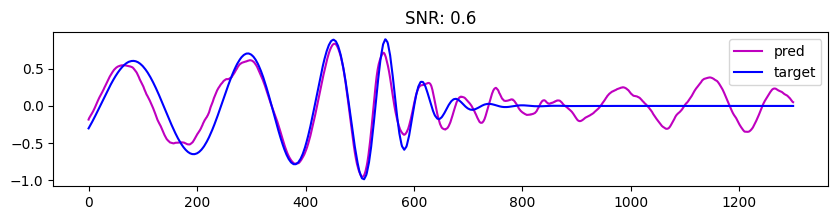

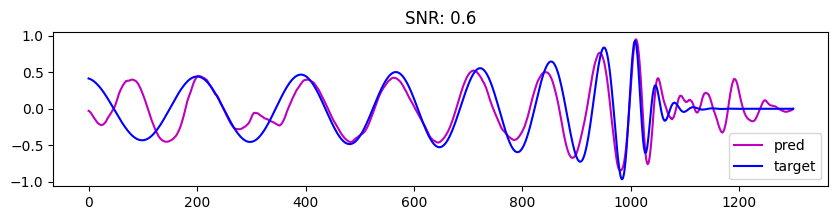

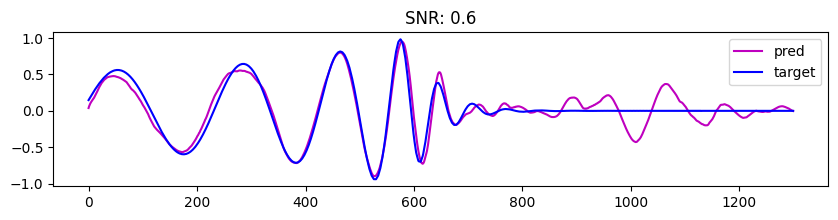

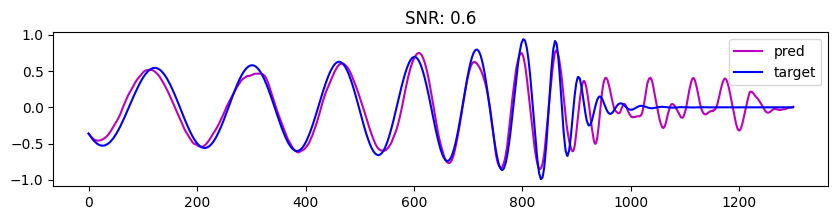

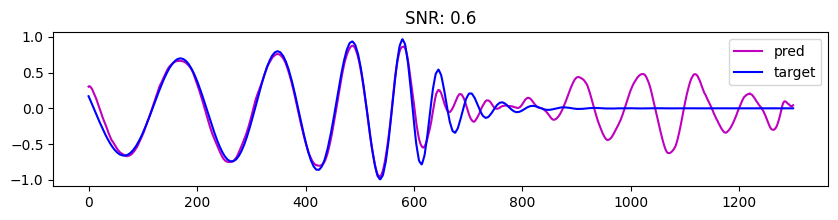

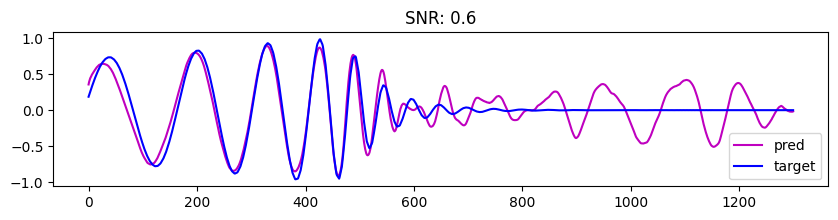

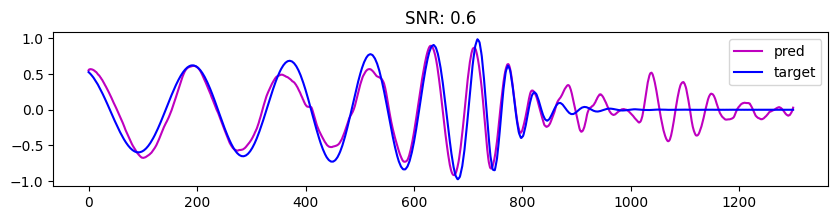

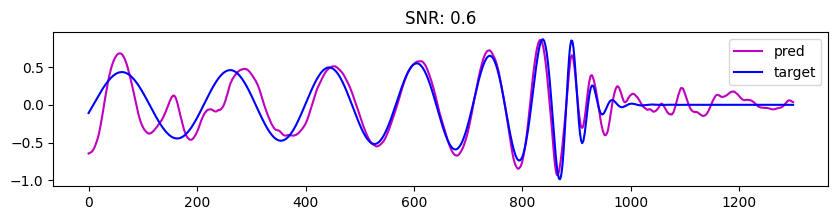

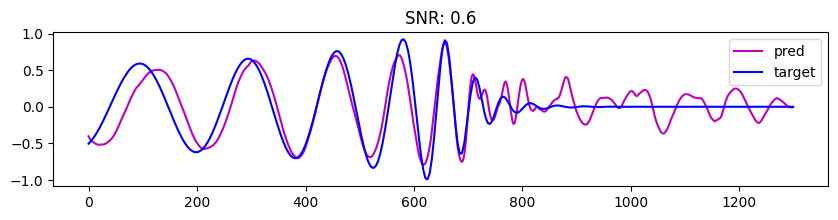

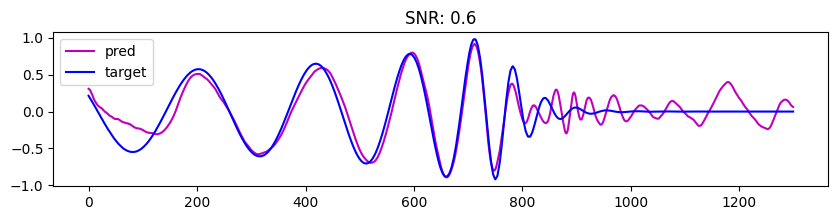

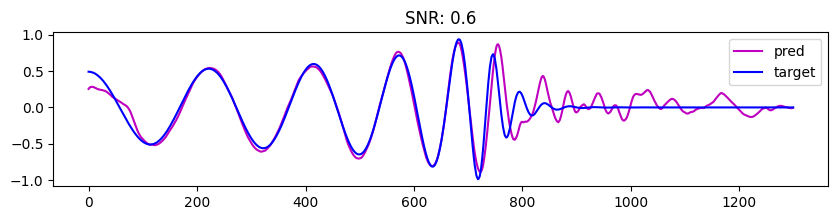

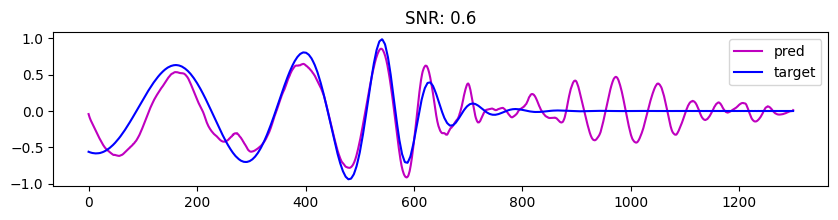

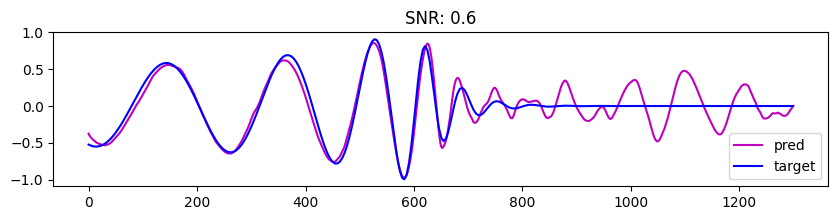

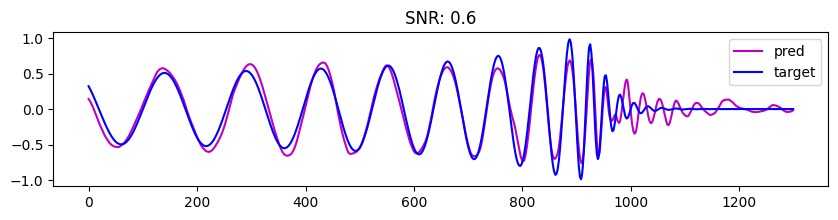

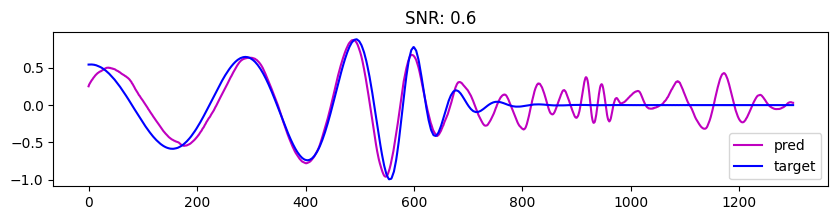

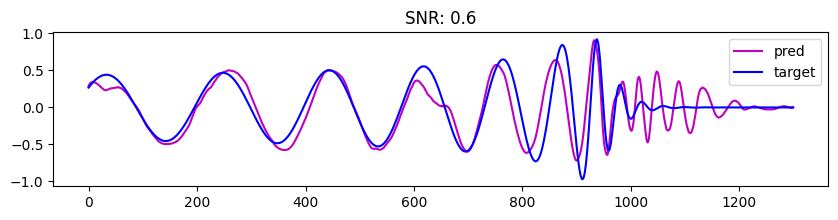

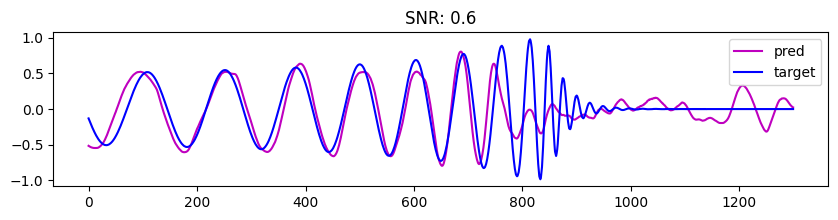

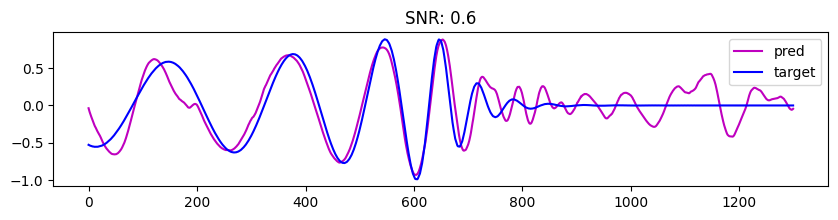

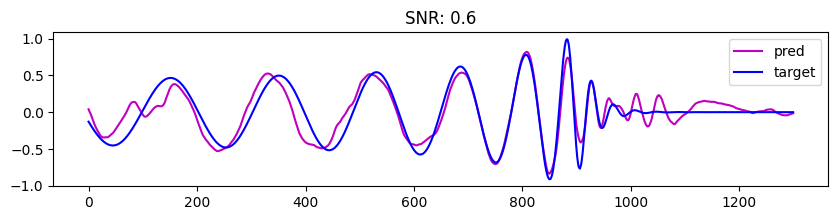

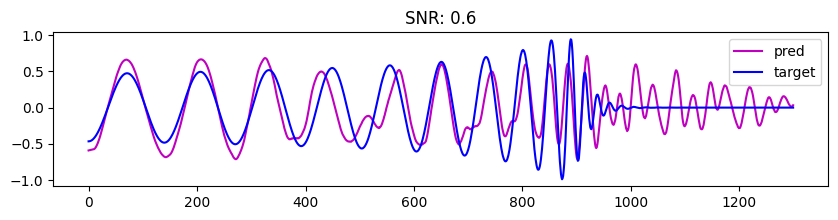

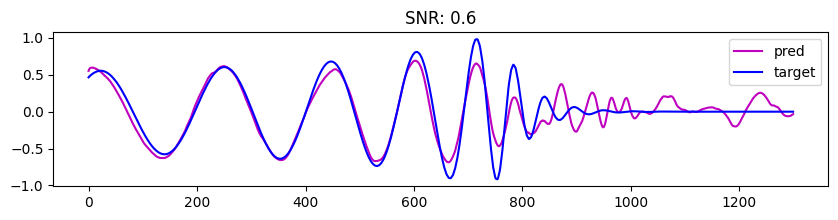

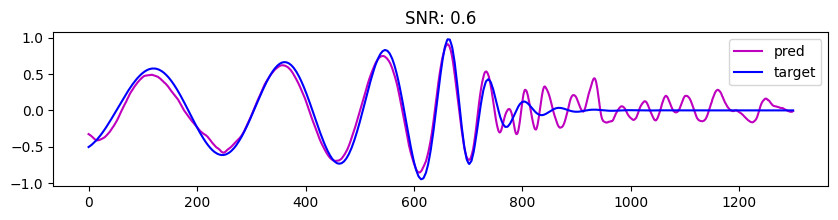

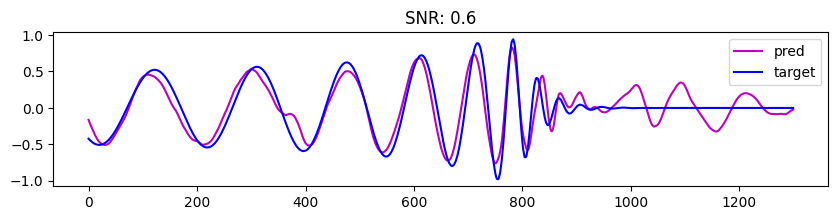

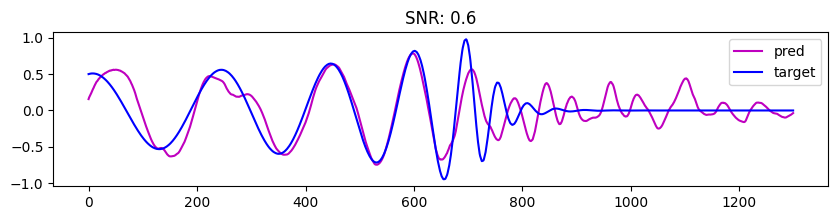

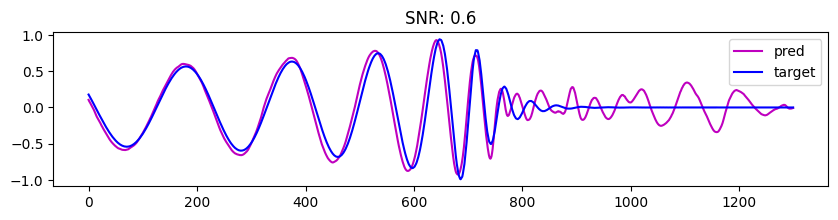

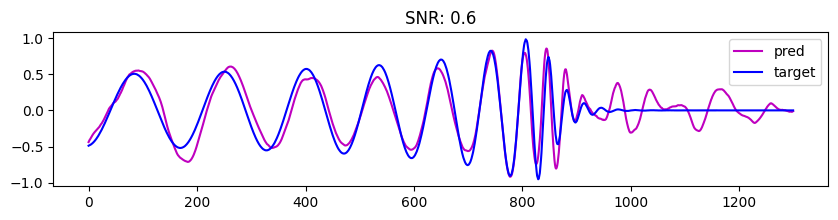

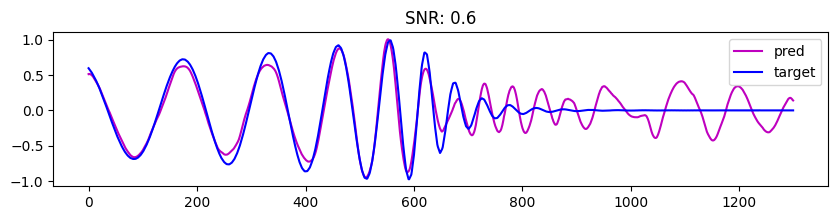

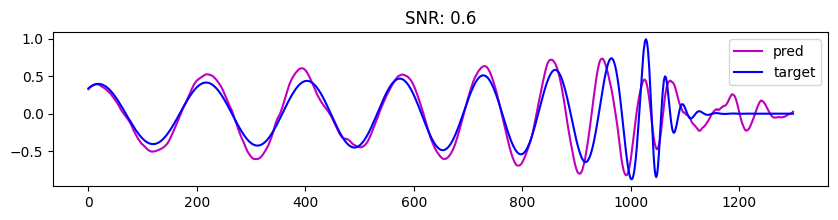

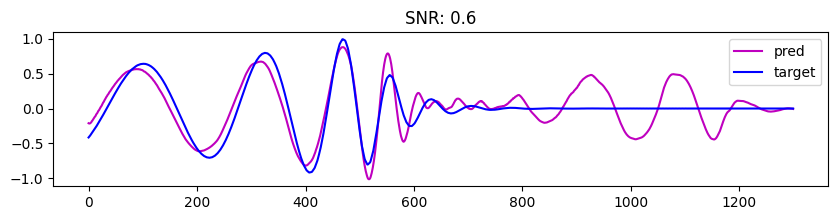

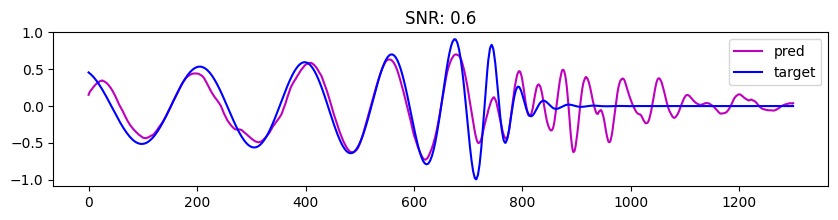

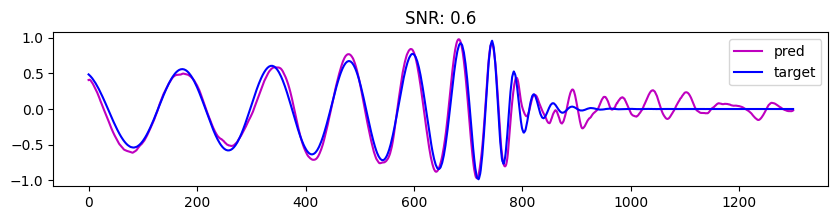

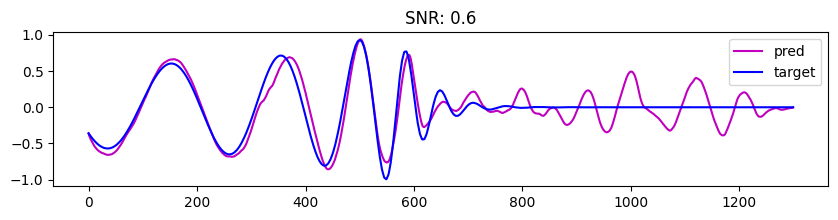

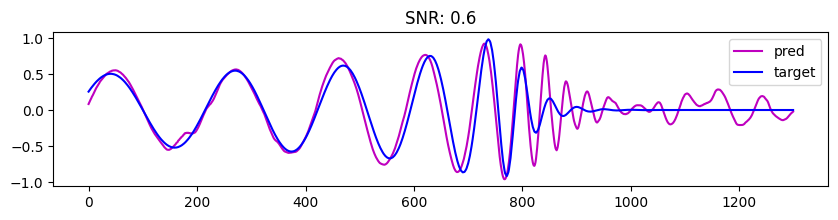

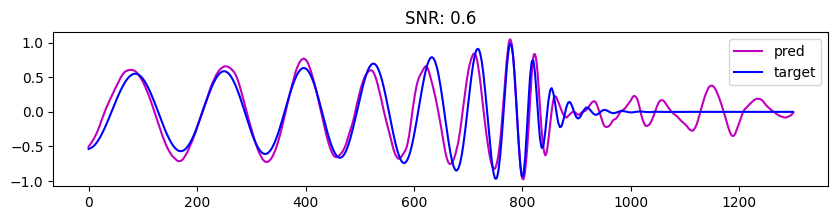

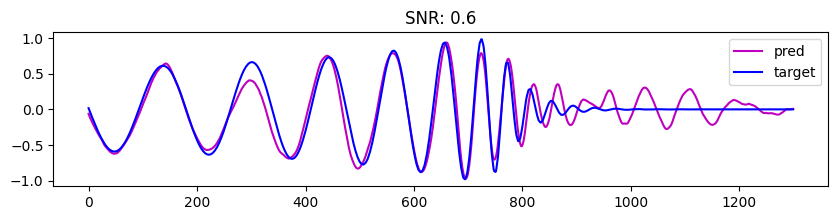

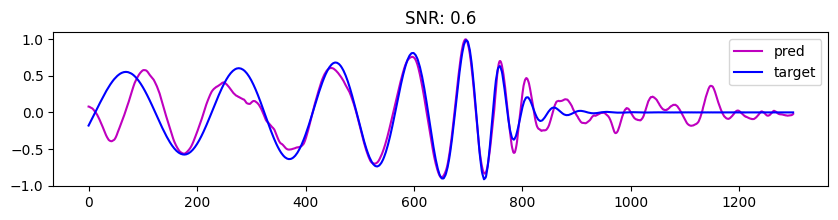

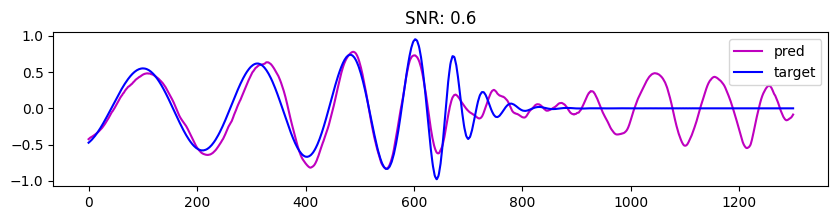

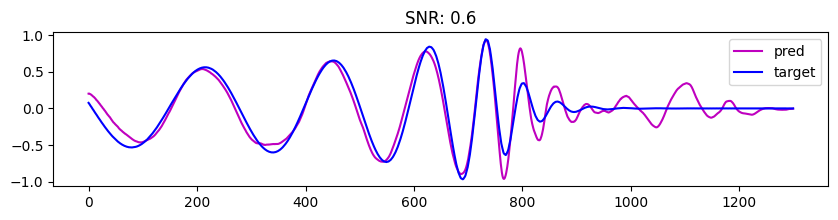

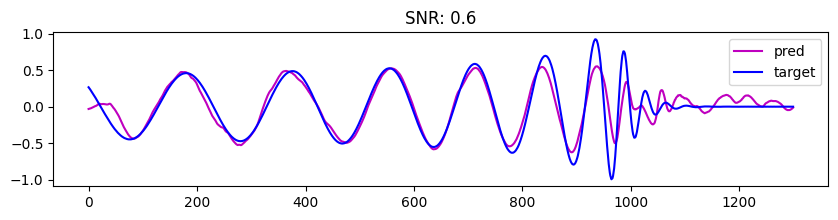

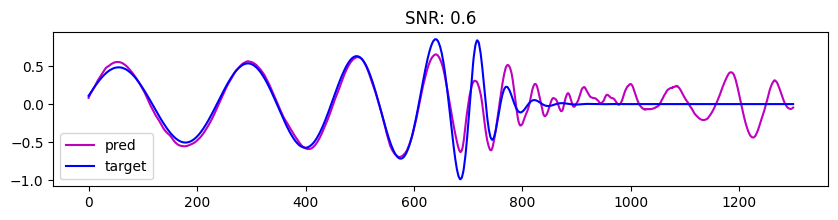

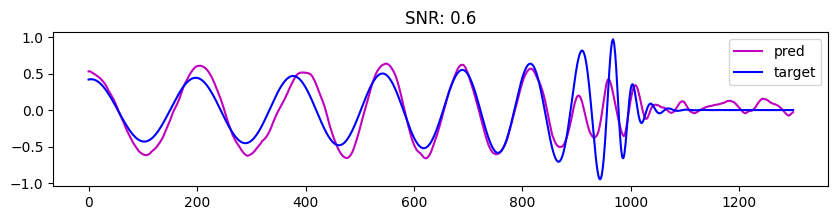

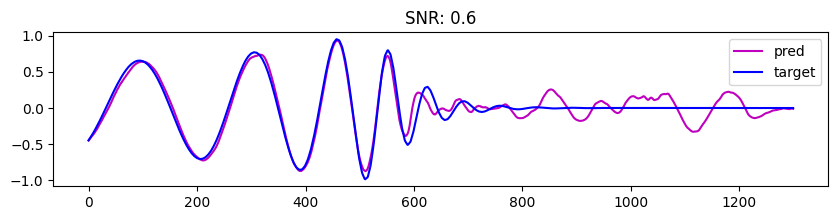

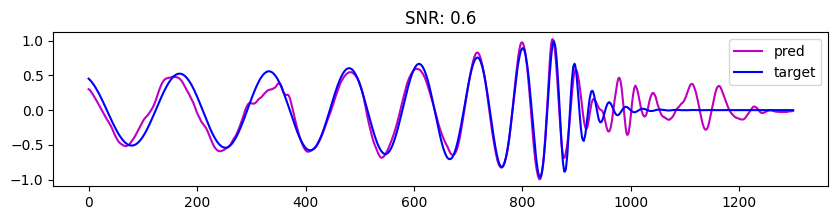

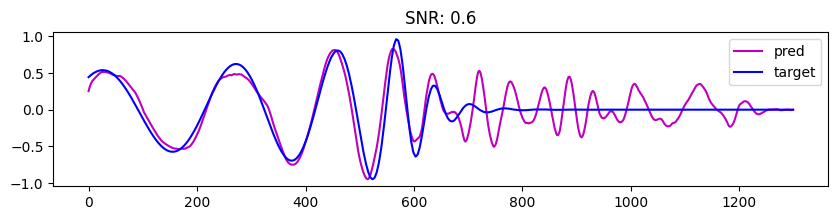

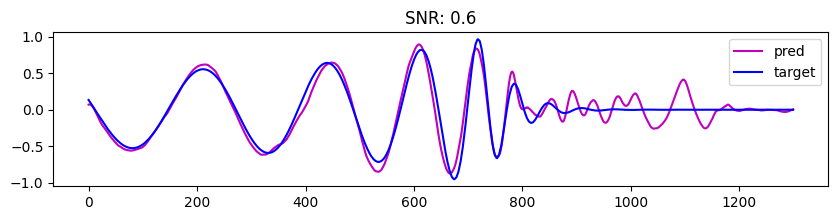

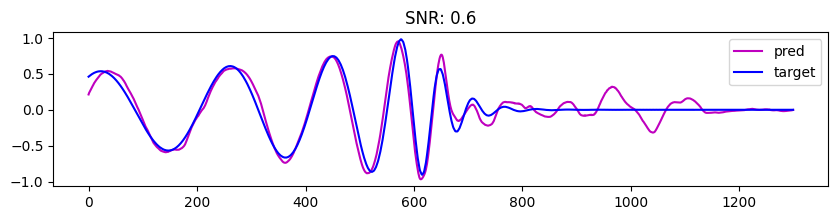

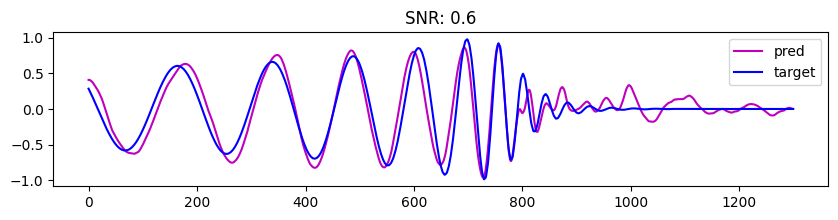

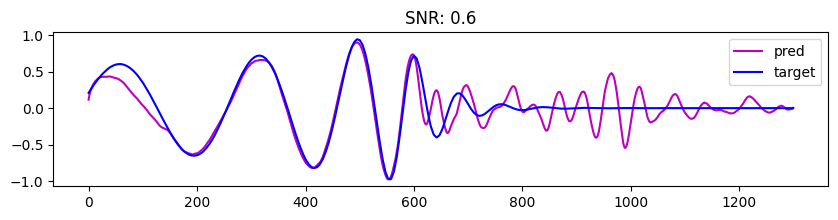

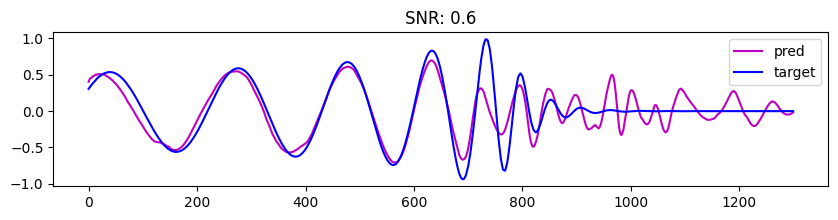

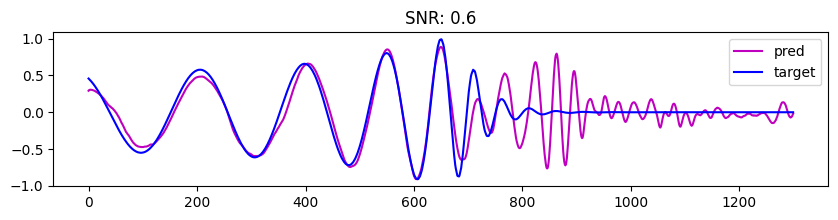

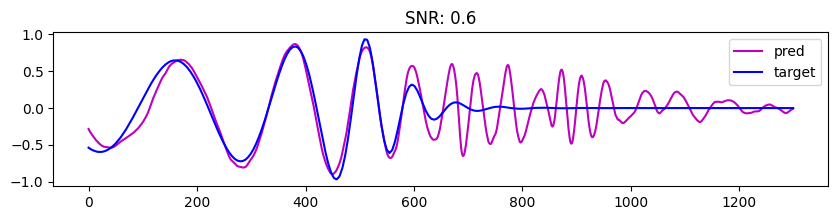

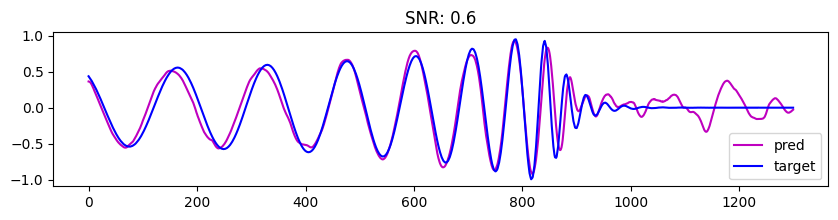

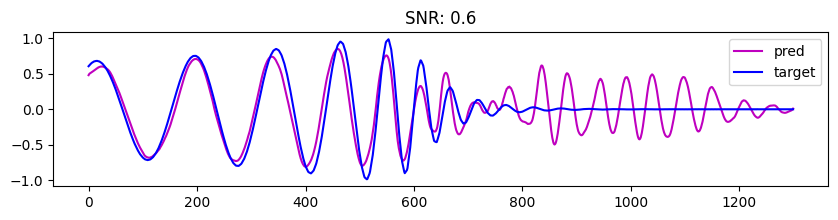

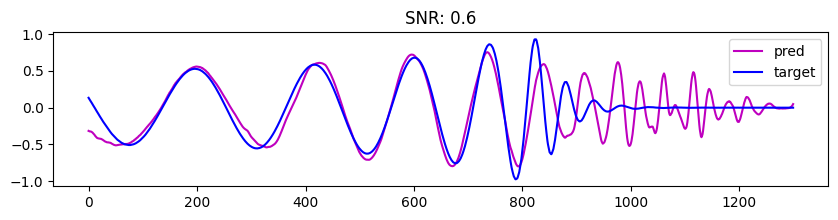

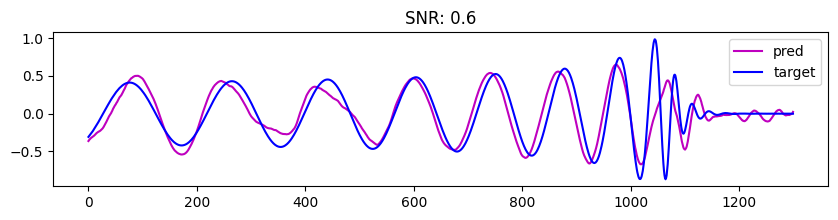

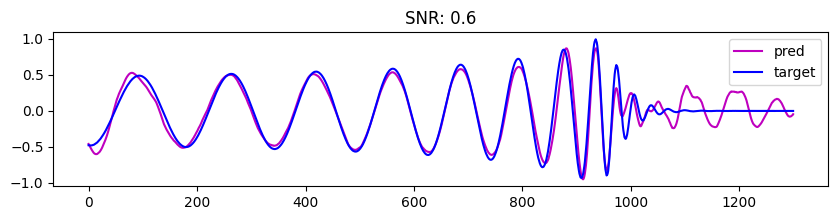

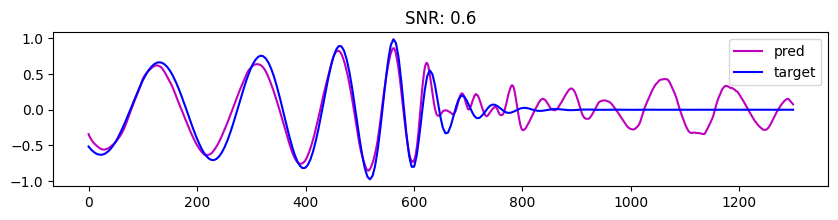

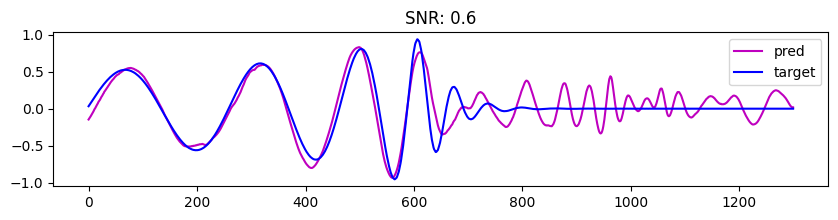

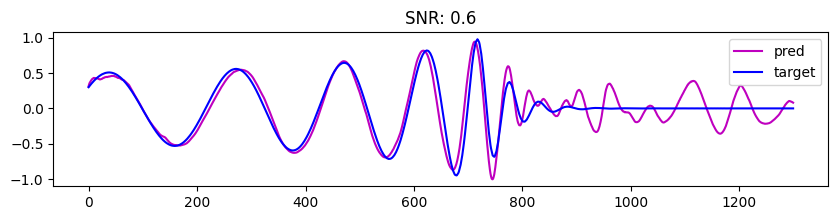

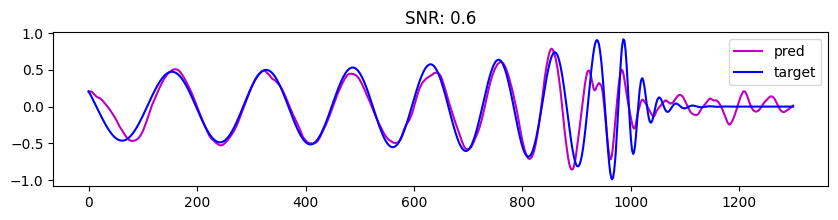

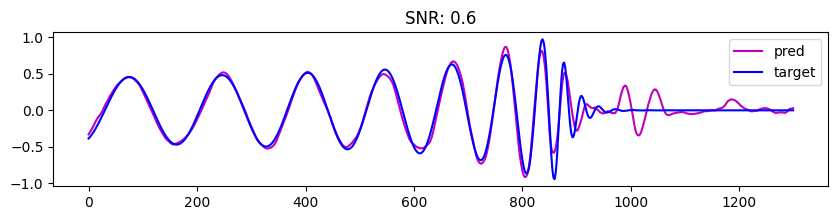

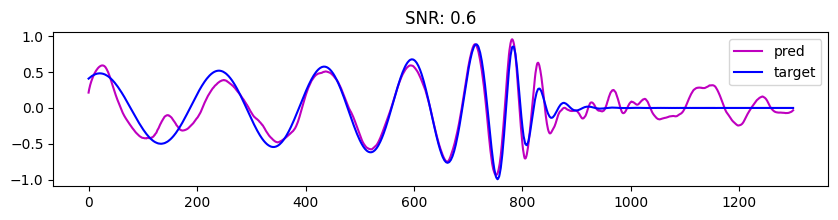

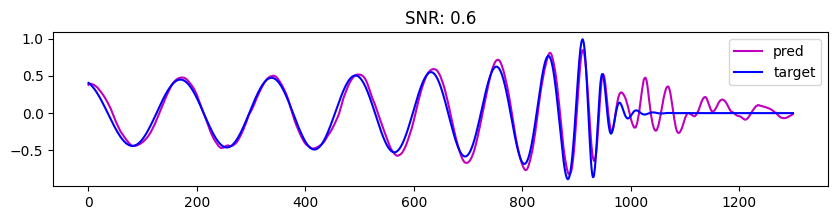

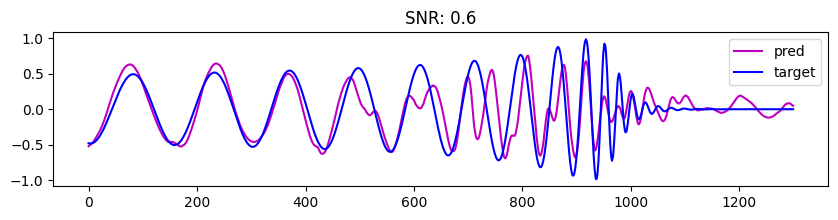

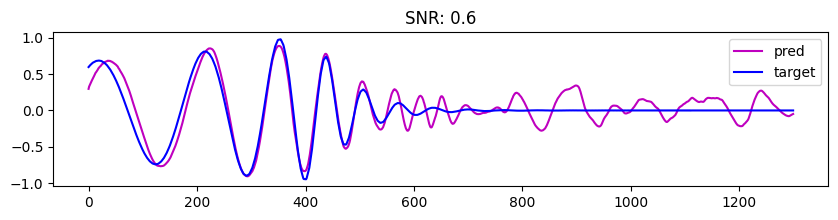

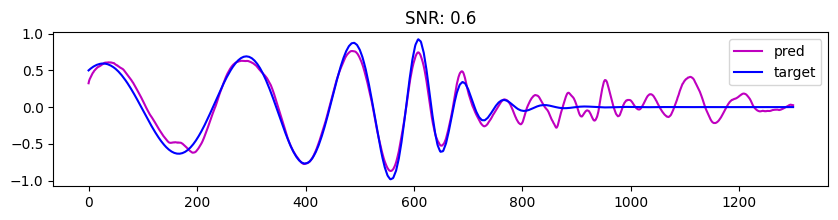

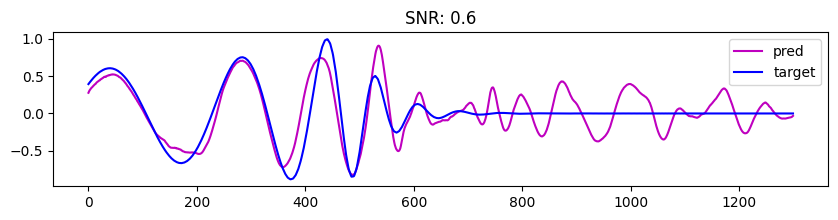

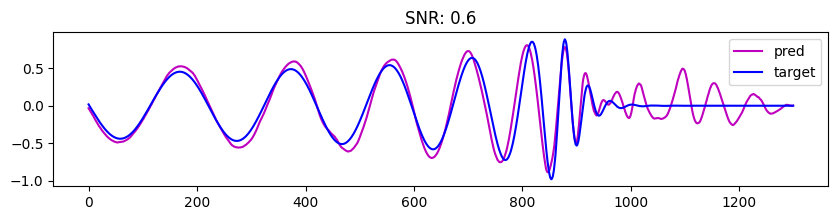

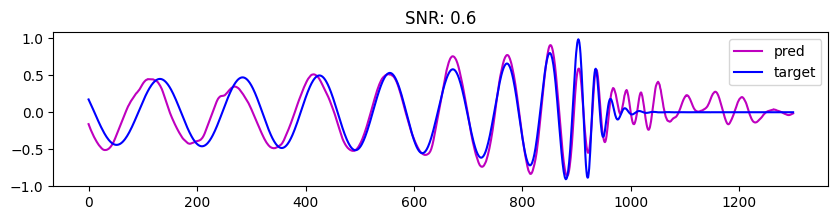

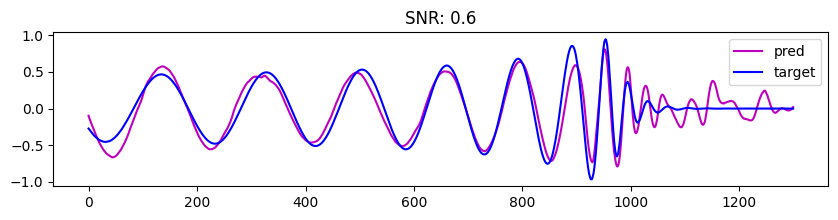

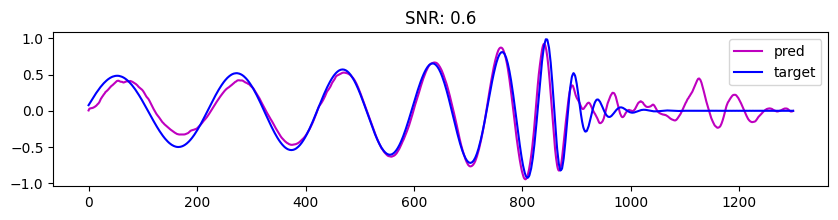

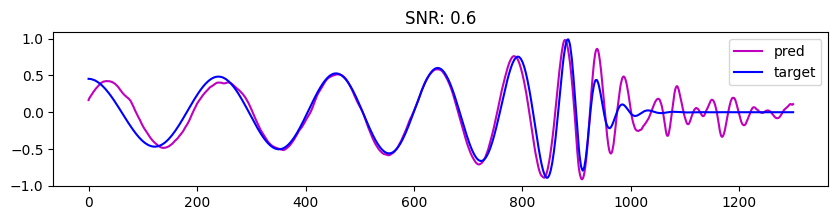

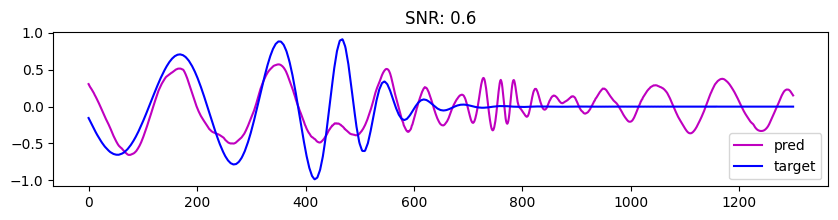

In [22]:
for i in range(100):
    fig = plt.figure(figsize=(10,2))
    plt.title('SNR: ' + str(snr))
    #plt.plot(test_noisy[i], color='gray',  alpha=0.3)
    plt.plot(predictions[i], color='m', label='pred')
    plt.plot(test[i], color='blue', label='target')
    plt.legend()
    plt.show()